Enter a 3-letter airport code for the US below, the date range you want, and how you want it aggregated: "Y" for year, "M" for month, "D" for day.

In [1]:
import json
import time
import datetime

# timestamps in UTC to request data for
startts = datetime.datetime(2000, 1, 1)
endts = datetime.datetime(2019, 12, 31)
station = "SFB"
aggregate = "Y"

Look up the time zone for your airport code, so we can convert times to local times.

In [2]:
zones = {}
with open('iata.tzmap.txt', 'r') as inf:
    for line in inf:
        (iata, tz) = line.split()
        zones[iata] = tz

timezone = zones[station]
print(timezone)

America/New_York


The code below is straight from https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py

In [3]:
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen
    
# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

In [4]:
def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist(filename):
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = []
    states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
     MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
     WA WI WV WY"""
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations

In [5]:
"""Our main method"""

service = SERVICE + "data=skyc1&tz=Etc/UTC&format=onlycomma&latlon=no&missing=empty&trace=T&direct=no&report_type=2&"
service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

uri = "%s&station=%s" % (service, station)
print("Downloading: %s" % (station,))
data = download_data(uri)
outfn = "%s.txt" % (
    station
)
out = open(outfn, "w")
out.write(data)
out.close()

Downloading: SFB


OK, so now we have a data file of METAR sky coverage data containing every individual measurement in the time period requested for a given airport. Let's load it up so we can mess with it.

In [6]:
import pandas as pd
df = pd.read_csv(station + '.txt')

Drop missing data

In [7]:
print(df.count())
df = df[df.skyc1 != '   ']
print(df.count())
print(df.groupby(df.skyc1).count())

station    195357
valid      195357
skyc1      195297
dtype: int64
station    195184
valid      195184
skyc1      195124
dtype: int64
       station   valid
skyc1                 
BKN      20776   20776
CLR     102087  102087
FEW      35612   35612
OVC      12543   12543
SCT      21853   21853
VV        2253    2253


Convert the timestamps into datetime objects, and convert them to local time (so we can tell what is night vs. day)

In [8]:
df['utctime'] = pd.to_datetime(df['valid'], format='%Y-%m-%d %H:%M', utc=True)
df['localtime'] = df['utctime'].dt.tz_convert(timezone)

In [9]:
df.head()

,station,valid,skyc1,utctime,localtime
0,SFB,2000-01-01 00:53,FEW,2000-01-01 00:53:00+00:00,1999-12-31 19:53:00-05:00
1,SFB,2000-01-01 01:53,CLR,2000-01-01 01:53:00+00:00,1999-12-31 20:53:00-05:00
2,SFB,2000-01-01 02:53,CLR,2000-01-01 02:53:00+00:00,1999-12-31 21:53:00-05:00
3,SFB,2000-01-01 03:53,BKN,2000-01-01 03:53:00+00:00,1999-12-31 22:53:00-05:00
4,SFB,2000-01-01 04:53,FEW,2000-01-01 04:53:00+00:00,1999-12-31 23:53:00-05:00


Now we'll add 3 boolean columns: is_nighttime, is_clear, and is_notclear. We define "night" as 6 PM - 6 AM. Also, we define "clear" as the "CLR" METAR code. If you're willing to observe when a few clouds are present, you could include "FEW" observations as well (although you would then want to look at the skyc2 and skyc3 fields as well to see if denser clouds existing in a layer above the "few" layer - it gets complicated.)

In [10]:
df['hour'] = df['localtime'].dt.hour
df['is_night'] = df['localtime'].dt.hour > 17 
df['is_morning'] = df['localtime'].dt.hour < 6
df['is_nighttime'] = df['is_night'] | df['is_morning']
df['is_clear'] = df['skyc1'] == 'CLR'
df['is_notclear'] = df['skyc1'] != 'CLR'
df = df.drop(['station', 'valid', 'is_night', 'is_morning'], axis=1)

In [11]:
df.head()

,skyc1,utctime,localtime,hour,is_nighttime,is_clear,is_notclear
0,FEW,2000-01-01 00:53:00+00:00,1999-12-31 19:53:00-05:00,19,True,False,True
1,CLR,2000-01-01 01:53:00+00:00,1999-12-31 20:53:00-05:00,20,True,True,False
2,CLR,2000-01-01 02:53:00+00:00,1999-12-31 21:53:00-05:00,21,True,True,False
3,BKN,2000-01-01 03:53:00+00:00,1999-12-31 22:53:00-05:00,22,True,False,True
4,FEW,2000-01-01 04:53:00+00:00,1999-12-31 23:53:00-05:00,23,True,False,True


Drop any rows that are not at night, drop some of the columns we don't care about, and clamp all timestamps to the aggregation period we want.

In [12]:
df_night = df[df['is_nighttime']]
df_night = df_night.drop(['skyc1', 'hour', 'utctime', 'is_nighttime'], axis=1)
df_night['period'] = df_night['localtime'].values.astype('datetime64[' + aggregate + ']')
df_night.head(100)

,localtime,is_clear,is_notclear,period
0,1999-12-31 19:53:00-05:00,False,True,2000-01-01
1,1999-12-31 20:53:00-05:00,True,False,2000-01-01
2,1999-12-31 21:53:00-05:00,True,False,2000-01-01
3,1999-12-31 22:53:00-05:00,False,True,2000-01-01
4,1999-12-31 23:53:00-05:00,False,True,2000-01-01
...,...,...,...,...
160,2000-01-05 20:53:00-05:00,False,True,2000-01-01
161,2000-01-05 21:53:00-05:00,False,True,2000-01-01
162,2000-01-05 22:53:00-05:00,False,True,2000-01-01
163,2000-01-05 23:53:00-05:00,False,True,2000-01-01


Split the data into different dataframes for clear and not-clear observations.

In [13]:
df_clearhours = df_night[df_night['is_clear']]
print (df_clearhours.head())
df_notclearhours = df_night[df_night['is_notclear']]
print (df_notclearhours.head())

                   localtime  is_clear  is_notclear     period
1  1999-12-31 20:53:00-05:00      True        False 2000-01-01
2  1999-12-31 21:53:00-05:00      True        False 2000-01-01
5  2000-01-01 00:53:00-05:00      True        False 2000-01-01
14 2000-01-01 18:53:00-05:00      True        False 2000-01-01
15 2000-01-01 19:53:00-05:00      True        False 2000-01-01
                   localtime  is_clear  is_notclear     period
0  1999-12-31 19:53:00-05:00     False         True 2000-01-01
3  1999-12-31 22:53:00-05:00     False         True 2000-01-01
4  1999-12-31 23:53:00-05:00     False         True 2000-01-01
19 2000-01-01 23:53:00-05:00     False         True 2000-01-01
21 2000-01-02 01:53:00-05:00     False         True 2000-01-01


Now perform the actual aggregation by day / month / year (whatever you asked for)

In [14]:
clearHours = df_clearhours.groupby('period').count()
notclearHours = df_notclearhours.groupby('period').count()

Now merge the two together again, calculating the percentage of observations that reported "clear" for each time period.

In [15]:
totals = clearHours
totals['clearhours'] = clearHours['is_clear']
totals['notclearHours'] = notclearHours['is_clear']
totals = totals.fillna(0)
totals['percentClear'] = totals['clearhours'] / (totals['clearhours'] + totals['notclearHours'])
totals.drop(['is_clear', 'is_notclear'], axis=1)
totals.head()

,localtime,is_clear,is_notclear,clearhours,notclearHours,percentClear
period,,,,,,
2000-01-01,3076,3076,3076,3076,1761,0.635931
2001-01-01,2733,2733,2733,2733,1568,0.635434
2002-01-01,2883,2883,2883,2883,1457,0.664286
2003-01-01,2794,2794,2794,2794,1522,0.647359
2004-01-01,2851,2851,2851,2851,1477,0.658734


Plot the results, and save it to a file.

E:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


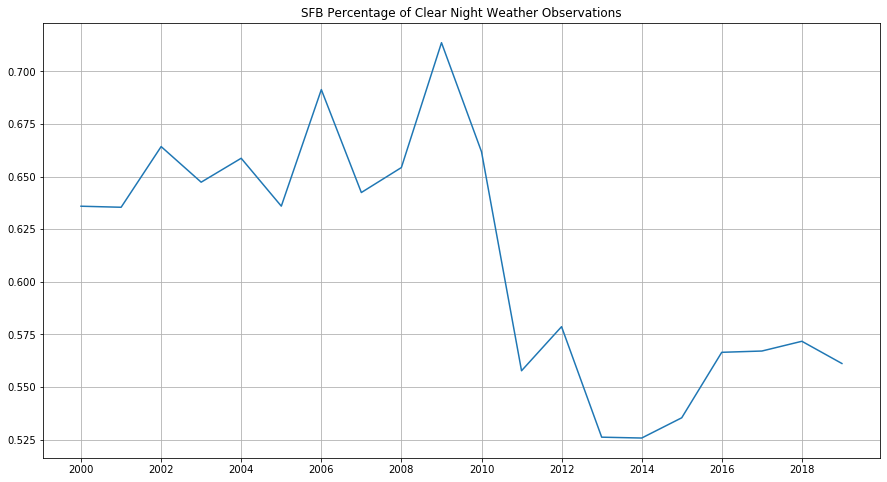

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(totals['percentClear'])
fig = plt.gcf()
plt.grid(True)
fig.set_size_inches(15, 8)
plt.title(station + " Percentage of Clear Night Weather Observations")
plt.savefig(station + ".png", bbox_inches='tight')
plt.show()
